<a href="https://colab.research.google.com/github/javsec/repositorio/blob/main/Analisis_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 6.3 MB/s 


In [40]:
import pandas as pd 
import numpy as np 
%matplotlib inline
import nltk
# from spellchecker import SpellChecker
import spacy  # Procesamiento NLP

from spellchecker import SpellChecker

import re  # Procesamiento de Texto
from time import time  # Medir tiempo de ejecucion
from collections import defaultdict  

import matplotlib.pyplot as plt

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Configuración matplotlib
# ==============================================================================

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

     


In [41]:
# cargamos datos 
url = 'https://raw.githubusercontent.com/patofw/imf_master/master/Notebooks/data/Tweets.csv'
data = pd.read_csv(url)
data.head(2)





,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [42]:
data.info()



# eliminamos la confianza menor a 0.7
to_model_data = data[data.airline_sentiment_confidence >=.7]




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Text(0.5, 1.0, 'Conteo Aerolinea')

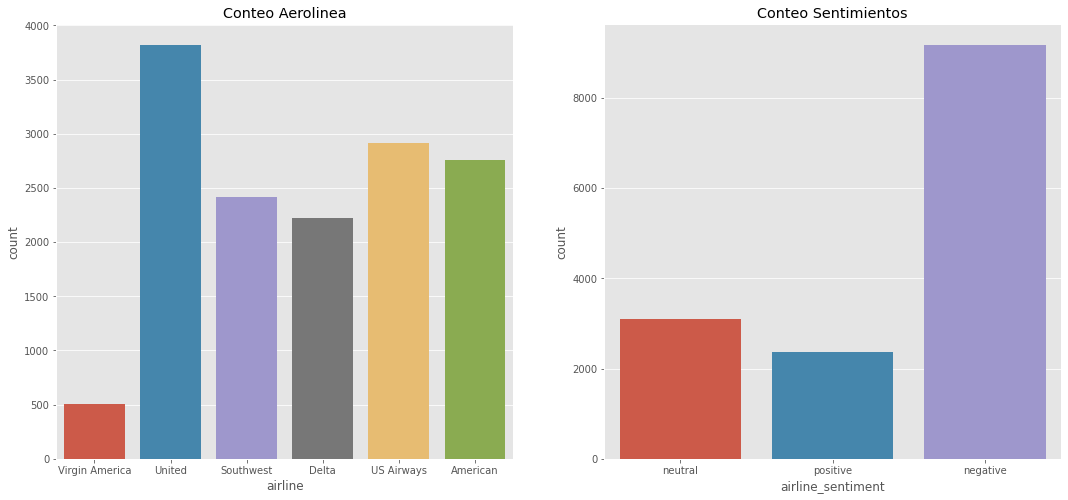

In [43]:




f , ax = plt.subplots (1,2, figsize = (18,8))

sns.countplot('airline_sentiment', data=data )

sns.countplot('airline', data=data,  ax = ax[0])



ax[1].set_title('Conteo Sentimientos')
ax[0].set_title('Conteo Aerolinea')



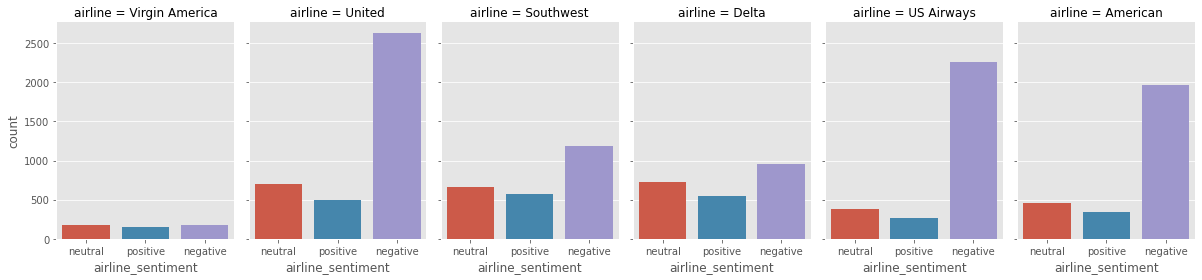

In [44]:
g = sns.catplot(x="airline_sentiment", col="airline",
                data=data, kind="count",height=4, aspect=.7);

In [45]:
# Cargamos los métodos de Spacy en Ingles 
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # Quitamos el Named Entity Recognition por facilidad de procesamiento
spell = SpellChecker() # Corrector
# Reemplazos para Tweeter
replacements = [
            '((www\.[^\s]+)|(https?://[^\s]+))', # url_replace 
            '@[^\s]+', # user_replace 
            '#([^\s]+)', # hash_replace
            "[^A-Za-z' ]+"  # eliminamos todo lo que no sea una letra
            ]

# Re nos permite compilar varias transformaciones en un solo iterador, 
# así nos evitamos iterar varias veces por el mismo documento, incrementando eficiencia. 
regex = re.compile('|'.join(r for r in replacements),re.IGNORECASE)


def limpia_tweets(tweet,spellchecker=False): 
  """ 
  Función práctica para limpiar y pre-procesar tweets. Incluye: 
  - Eliminación de Hashtags, urls y usuarios 
  - Tokenización 
  - corrector gramatical (inglés)
  :param tweet: String, cadena de texto, idealmente un Tweet
  :return: Una lista con tokens de tweet.  
  """
  # empezamos transformando a minúsculas
  clean_tweet = tweet.lower()
  # Limpiamos Usuario, Urls y Hashtags
  clean_tweet = regex.sub('', clean_tweet)
  # Añadimos limpieza de caracteres repetidos
  clean_tweet = re.sub(r'(.)\1+', r'\1\1', clean_tweet).split()
  if spellchecker:
    # Encuentra las que tienen errores
    misspelled = spell.unknown(clean_tweet)
    # Corregimos el tweet. 
    clean_tweet = [
        spell.correction(word) if word in misspelled else word for word in clean_tweet]
  return ' '.join(clean_tweet)

In [46]:
def cleaning(doc):
  """
  Lemmatiza y elimina stopwords
  Necesitamos un doc como lo describe spacy
  :param doc: DOC según lo describe Spacy. 
  :return: Una cadena de texto. 
  """
  
  txt = [token.lemma_ for token in doc if not token.is_stop]
  return ' '.join(txt)
# Funcion de limpieza del tweet que entrará al pipe de Spacy(NLP)
tweet_cleaning = (limpia_tweets(row) for row in to_model_data['text'])

In [48]:
# Test
limpia_tweets('hapy panda day @snafranci, really enjoying this #Gloriousafternoon', True)

'happy panda day really enjoying this'

In [49]:
from time import time  # Medir tiempo de ejecucion
t = time() # Calculamos tiempo

txt = [cleaning(doc) for doc in nlp.pipe(tweet_cleaning, # función que def antes
                                         batch_size=5000, 
                                        # n_threads=-1 # ERROR
                                         n_process=-1 # usamos todos los cores
                                         )]
t_ = round((time() - t) / 60, 2) # Tiempo de ejecucion en mins
print(f'Tiempo de ejecución: {t_} mins')

Tiempo de ejecución: 0.43 mins


In [50]:
txt[:10]

['say',
 "aggressive blast obnoxious entertainment guest ' face amp little recourse",
 'big bad thing',
 'seriously pay flight seat playingit bad thing fly va',
 'amazing arrive hour early good',
 'lt pretty graphic well minimal iconography d',
 'great deal think nd trip amp go st trip p',
 'thank',
 'excited cross country flight lax mco hear great thing virgin america',
 'fly nyc sfo week fully sit seat large gentleman help']

In [38]:
to_model_data['clean_text'] = txt

In [51]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [52]:
sent = SentimentIntensityAnalyzer()

In [53]:
from tqdm.notebook import tqdm # barra de progreso
# Extraemos los sentimientos de cada uno de los reviews
sentiments = [sent.polarity_scores(text) for text in tqdm(txt)]

  0%|          | 0/10768 [00:00<?, ?it/s]

In [55]:
# Tenemos el diccionario completo, y se podra utilizar algunas de las otras valencias 
sentiments[:5]

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.343, 'neu': 0.448, 'pos': 0.209, 'compound': -0.2023},
 {'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'compound': -0.5423},
 {'neg': 0.524, 'neu': 0.476, 'pos': 0.0, 'compound': -0.6808},
 {'neg': 0.0, 'neu': 0.309, 'pos': 0.691, 'compound': 0.7717}]

In [56]:
# Sacamos los valores 
values = [d['compound'] for d in sentiments]

In [58]:
# Dataset 
to_model_data['valor_sentimiento'] = values

In [59]:
to_model_data['valor_sentimiento'].describe()

count    10768.000000
mean         0.039972
std          0.429507
min         -0.977900
25%         -0.296000
50%          0.000000
75%          0.361200
max          0.971600
Name: valor_sentimiento, dtype: float64

In [60]:
to_model_data.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,valor_sentimiento
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),0.0000
3,570301031407624196,negative,1.0,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),-0.2023
4,570300817074462722,negative,1.0,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),-0.5423
5,570300767074181121,negative,1.0,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),-0.6808
9,570295459631263746,positive,1.0,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada),0.7717
11,570289724453216256,positive,1.0,NaN,NaN,Virgin America,NaN,HyperCamiLax,NaN,0,@VirginAmerica I &lt;3 pretty graphics. so muc...,NaN,2015-02-24 10:30:40 -0800,NYC,America/New_York,0.6486
12,570289584061480960,positive,1.0,NaN,NaN,Virgin America,NaN,HyperCamiLax,NaN,0,@VirginAmerica This is such a great deal! Alre...,NaN,2015-02-24 10:30:06 -0800,NYC,America/New_York,0.6249
14,570285904809598977,positive,1.0,NaN,NaN,Virgin America,NaN,sjespers,NaN,0,@VirginAmerica Thanks!,NaN,2015-02-24 10:15:29 -0800,"San Francisco, CA",Pacific Time (US & Canada),0.3612
16,570277724385734656,positive,1.0,NaN,NaN,Virgin America,NaN,ItzBrianHunty,NaN,0,@VirginAmerica So excited for my first cross c...,NaN,2015-02-24 09:42:59 -0800,west covina,Pacific Time (US & Canada),0.7579
17,570276917301137409,negative,1.0,Bad Flight,1.0000,Virgin America,NaN,heatherovieda,NaN,0,@VirginAmerica I flew from NYC to SFO last we...,NaN,2015-02-24 09:39:46 -0800,this place called NYC,Eastern Time (US & Canada),0.4019


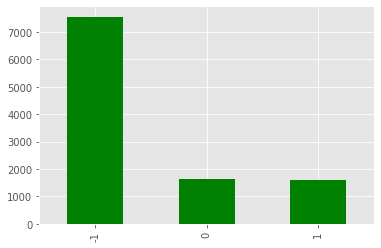

In [61]:
def map_labels(x: int):

    map_vals = {
       'negative':-1,
        'neutral':0,
        'positive':1,
    }
    return map_vals.get(x)

to_model_data['num_sentimental'] = to_model_data.airline_sentiment.apply(map_labels)
to_model_data.num_sentimental.value_counts().plot(kind="bar",color='green')

In [62]:
# Correlación 
to_model_data[['valor_sentimiento','num_sentimental']].corr()

,valor_sentimiento,num_sentimental
valor_sentimiento,1.000000,0.494628
num_sentimental,0.494628,1.000000


In [63]:
to_model_data.groupby('num_sentimental')['valor_sentimiento'].mean()

num_sentimental
-1   -0.079778
 0    0.117308
 1    0.531743
Name: valor_sentimiento, dtype: float64

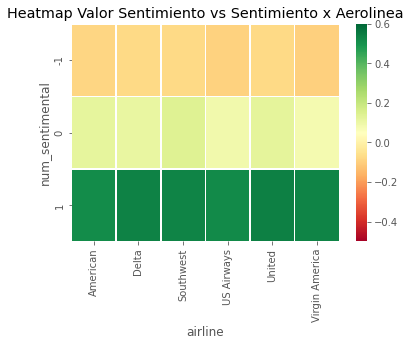

In [64]:
# Revisamos la relación con un mapa de calor 
g = to_model_data.groupby(['num_sentimental','airline'])['valor_sentimiento'].mean().unstack()
sns.heatmap(g,
            linewidths=.5, 
            cmap="RdYlGn", 
            vmin = -0.5,
            vmax = .6)
plt.title('Heatmap Valor Sentimiento vs Sentimiento x Aerolinea');

In [65]:
to_model_data.sort_values('num_sentimental').head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,valor_sentimiento,num_sentimental
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada),0.3818,-1
7397,569627374674964480,negative,1.0000,Bad Flight,0.7033,Delta,NaN,ThatJasonEaton,NaN,0,@JetBlue you're lucky we're still flying you a...,NaN,2015-02-22 14:38:43 -0800,NaN,NaN,0.2960,-1
7394,569627907871502338,negative,1.0000,Lost Luggage,0.6659,Delta,NaN,ericnax,NaN,0,"@JetBlue, thanks for not guarantee that you ca...",NaN,2015-02-22 14:40:51 -0800,NaN,Eastern Time (US & Canada),0.4404,-1
7392,569628159085301760,negative,1.0000,Flight Attendant Complaints,0.3578,Delta,NaN,ThatJasonEaton,NaN,0,@JetBlue This is absurd. Should a stranger hel...,NaN,2015-02-22 14:41:50 -0800,NaN,NaN,0.0000,-1
7391,569628172842479616,negative,0.7025,Can't Tell,0.3702,Delta,NaN,Crimson_Zombie,NaN,0,"@JetBlue sadly, no! I have the app, but it als...",NaN,2015-02-22 14:41:54 -0800,Chicago,NaN,-0.6369,-1
